# Guiding questions

How does graduate student gender diversity at Columbia compare to its peer institutions?

In [4]:
from collections import defaultdict
import math
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# https://stackoverflow.com/questions/19798112/convert-pandas-dataframe-to-a-nested-dict
def recur_dictify(frame):
    if len(frame.columns) == 1:
        if frame.values.size == 1: return frame.values[0][0]
        return frame.values.squeeze()
    grouped = frame.groupby(frame.columns[0])
    d = {k: recur_dictify(g.ix[:,1:]) for k,g in grouped}
    return d

def get_dataframe():
    df = pd.read_csv(
        '../../data/GSS_Export_Broad_Sex_RaceEthnicity.csv', 
        thousands=',',
        header=4, # starting at 4th row
        skipfooter=4, # ignore last 4 lines of data (footer)
        engine='python', # default pandas engine does not support skipfooter
        index_col=False, # don't use first column (year) as dataframe index
        names = ['Year', 'Institution Name', 'Broad Fields', 'Sex', 'Race and Ethnicity', 'Total']
    )

    # Delete some aggregate values we don't need for this analysis
    df = df[ df['Institution Name'] != 'Total for selected values' ]
    df = df[ df['Broad Fields'] != 'Total for selected values' ]

    # Rename all instances of 'Columbia Univ in the City of New York'
    # to 'Columbia University in the City of New York'
    df['Institution Name'] = df['Institution Name'].str.replace(
        'Columbia Univ in the City of New York', 
        'Columbia University in the City of New York'
    )    
    return df

try:
    TOTALS = pickle.load( open('../../data/GSS_Export_Broad_Sex_RaceEthnicity.p', 'rb') )
except FileNotFoundError:
    TOTALS = recur_dictify( get_dataframe() )
    with open('../../data/GSS_Export_Broad_Sex_RaceEthnicity.p', 'wb') as f:
        pickle.dump(totals, f)

In [55]:
years = sorted(TOTALS.keys())
institutions = sorted(TOTALS[ max(years) ].keys())
fields = sorted(TOTALS[ max(years) ]['Columbia University in the City of New York'].keys())
race_ethnicities = sorted(TOTALS[ max(years) ]['Columbia University in the City of New York'][ fields[0] ]['Female'].keys())
race_ethnicities.remove('Total for selected values')

print(f'Data set describes years {min(years)} - {max(years)} for the following institutions: {institutions}.')

Data set describes years 1994 - 2016 for the following institutions: ['Brown University', 'Columbia University in the City of New York', 'Cornell University', 'Dartmouth College', 'Duke University', 'Harvard University', 'Massachusetts Institute of Technology', 'Princeton University', 'Stanford University', 'University of Pennsylvania', 'Yale University'].


In [1]:
# Convenient function for making subplots for every institution
def subplots(num=len(institutions), size=10, cols=2):
    rows = math.ceil(num / cols)
    return plt.subplots(rows, cols, figsize=(size * cols, size * rows))

# Plots the proportion stackplot of a field
def stack_proportions(ax, inst, field):
    stacks = {r: [] for r in race_ethnicities}
    
    # Calculate each field's proportions over the years
    for year in years:
        field_counts = TOTALS[year][inst].get(field, None)
        if field_counts is None:
            [stacks[r].append(0) for r in race_ethnicities]
            continue
        total = field_counts['Total for selected values']['Total for selected values']
        for r in race_ethnicities:
            female = field_counts.get('Female', {}).get(r, 0)
            male = field_counts.get('Male', {}).get(r, 0)
            stacks[r].append((male + female) / total)

    ax.stackplot(years, stacks.values(), labels=stacks.keys())

    ax.set_title(inst + ', ' + field)
    ax.set_xlabel('Year')
    ax.legend()

    # Format y tick labels to be percentages
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

NameError: name 'institutions' is not defined

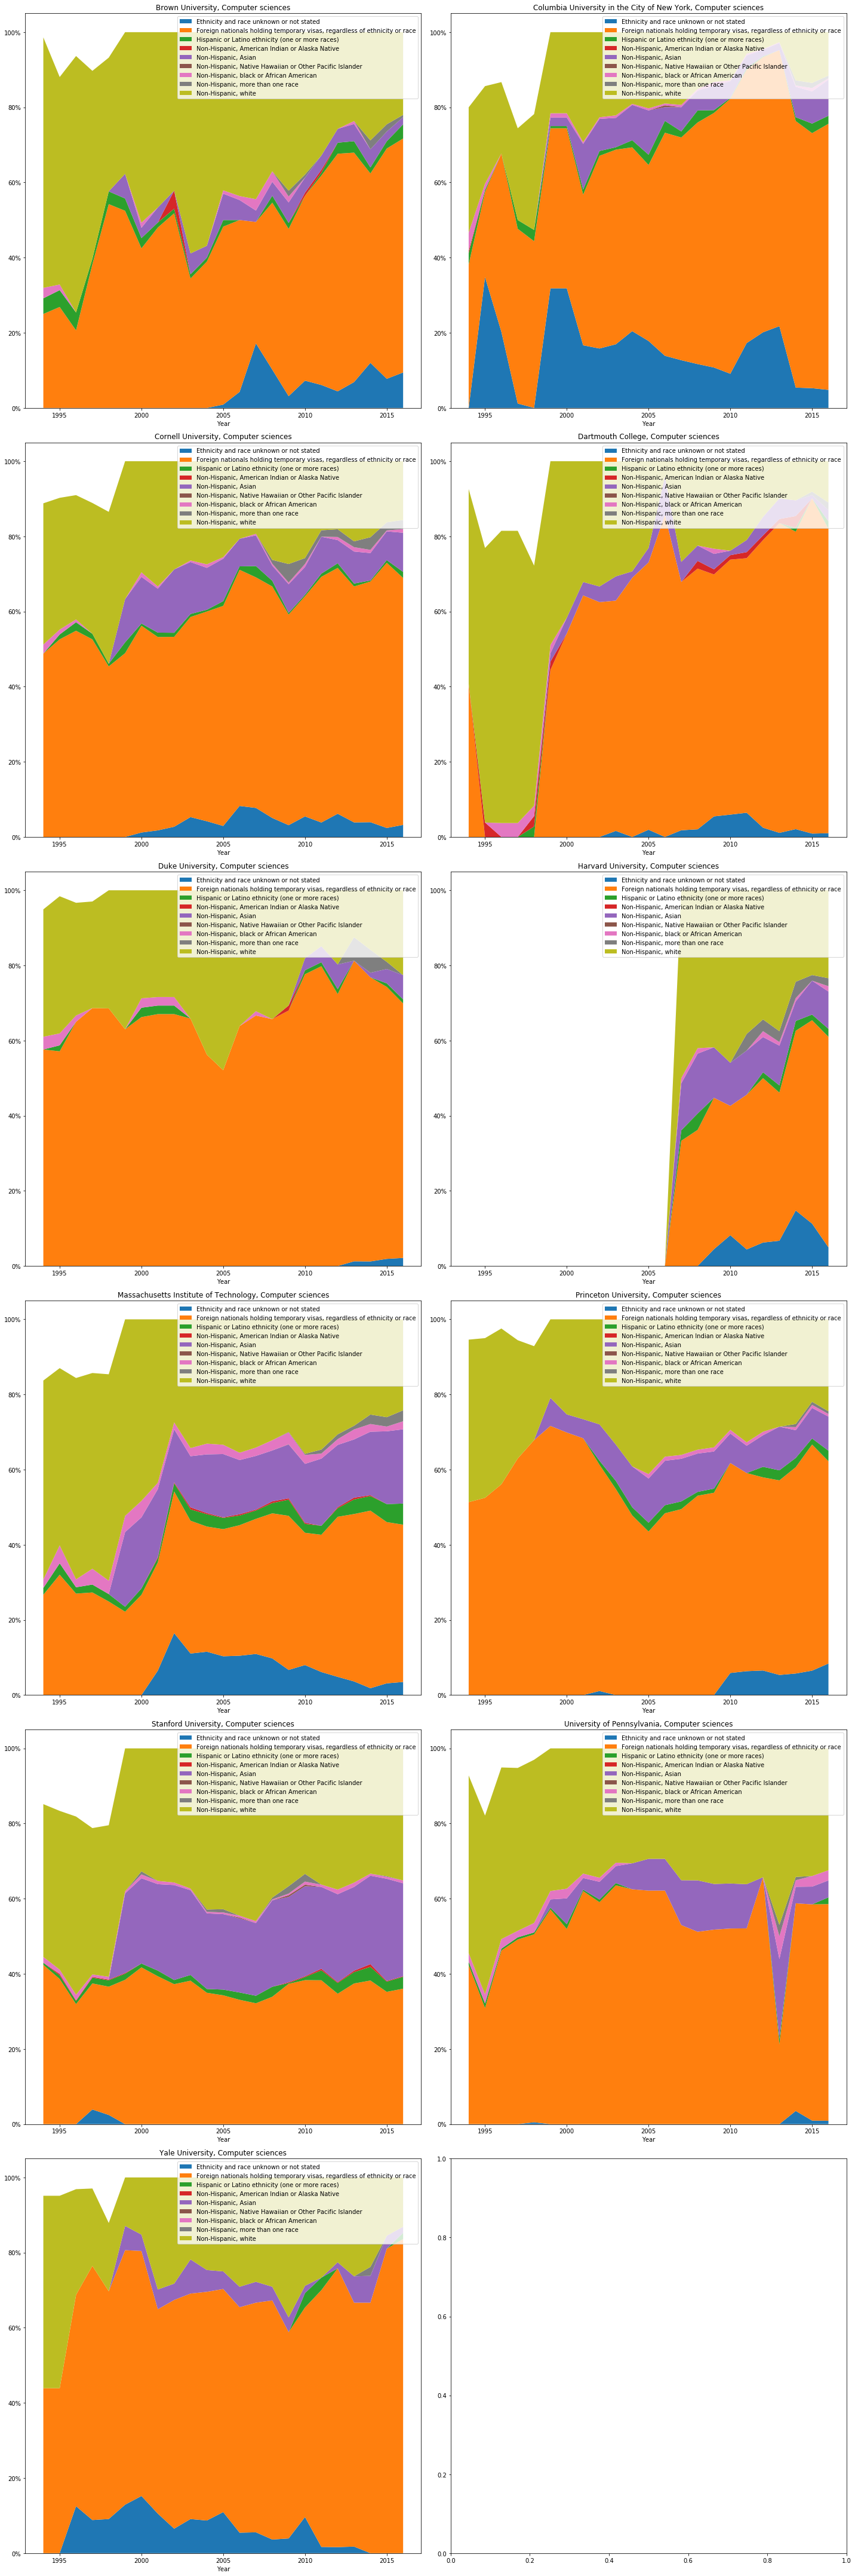

In [130]:
def compare_inst_stacks(field):
    fig, axArr = subplots()
    for i, inst in enumerate(institutions):
        ax = axArr[i // 2, i % 2]
        stack_proportions(ax, inst, field)
    fig.tight_layout()
    
compare_inst_stacks('Computer sciences')

In [91]:
def get_proportions(inst, field, race):
    proportions = []
    for year in years:
        field_counts = TOTALS[year][inst].get(field, None)
        if field_counts is None:
            proportions.append(None)
            continue
        total = field_counts['Total for selected values']['Total for selected values']
        female = field_counts.get('Female', {}).get(race, 0)
        male = field_counts.get('Male', {}).get(race, 0)
        proportions.append((male + female) / total)
    return proportions

# Plots the proportion stackplot of a field
def plot_proportions(ax, field, race, highlight='Columbia University in the City of New York'):
    for inst in institutions:
        if inst != highlight:
            ax.plot(years, get_proportions(inst, field, race), label=inst)
    ax.plot(years, get_proportions(highlight, field, race), label=highlight, linewidth=3)

    ax.set_title(field)
    ax.set_xlabel('Year')
    ax.set_ylim(bottom=0)

    # Format y tick labels to be percentages
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

In [107]:
def compare_insts_by_field(race):
    cols = 3
    fig, axArr = subplots(len(fields), size=5, cols=cols)
    for i, field in enumerate(fields):
        plot_proportions(axArr[ i // cols, i % cols ], field, race)
    fig.tight_layout()

print(race_ethnicities)

['Ethnicity and race unknown or not stated', 'Foreign nationals holding temporary visas, regardless of ethnicity or race', 'Hispanic or Latino ethnicity (one or more races)', 'Non-Hispanic, American Indian or Alaska Native', 'Non-Hispanic, Asian', 'Non-Hispanic, Native Hawaiian or Other Pacific Islander', 'Non-Hispanic, black or African American', 'Non-Hispanic, more than one race', 'Non-Hispanic, white']


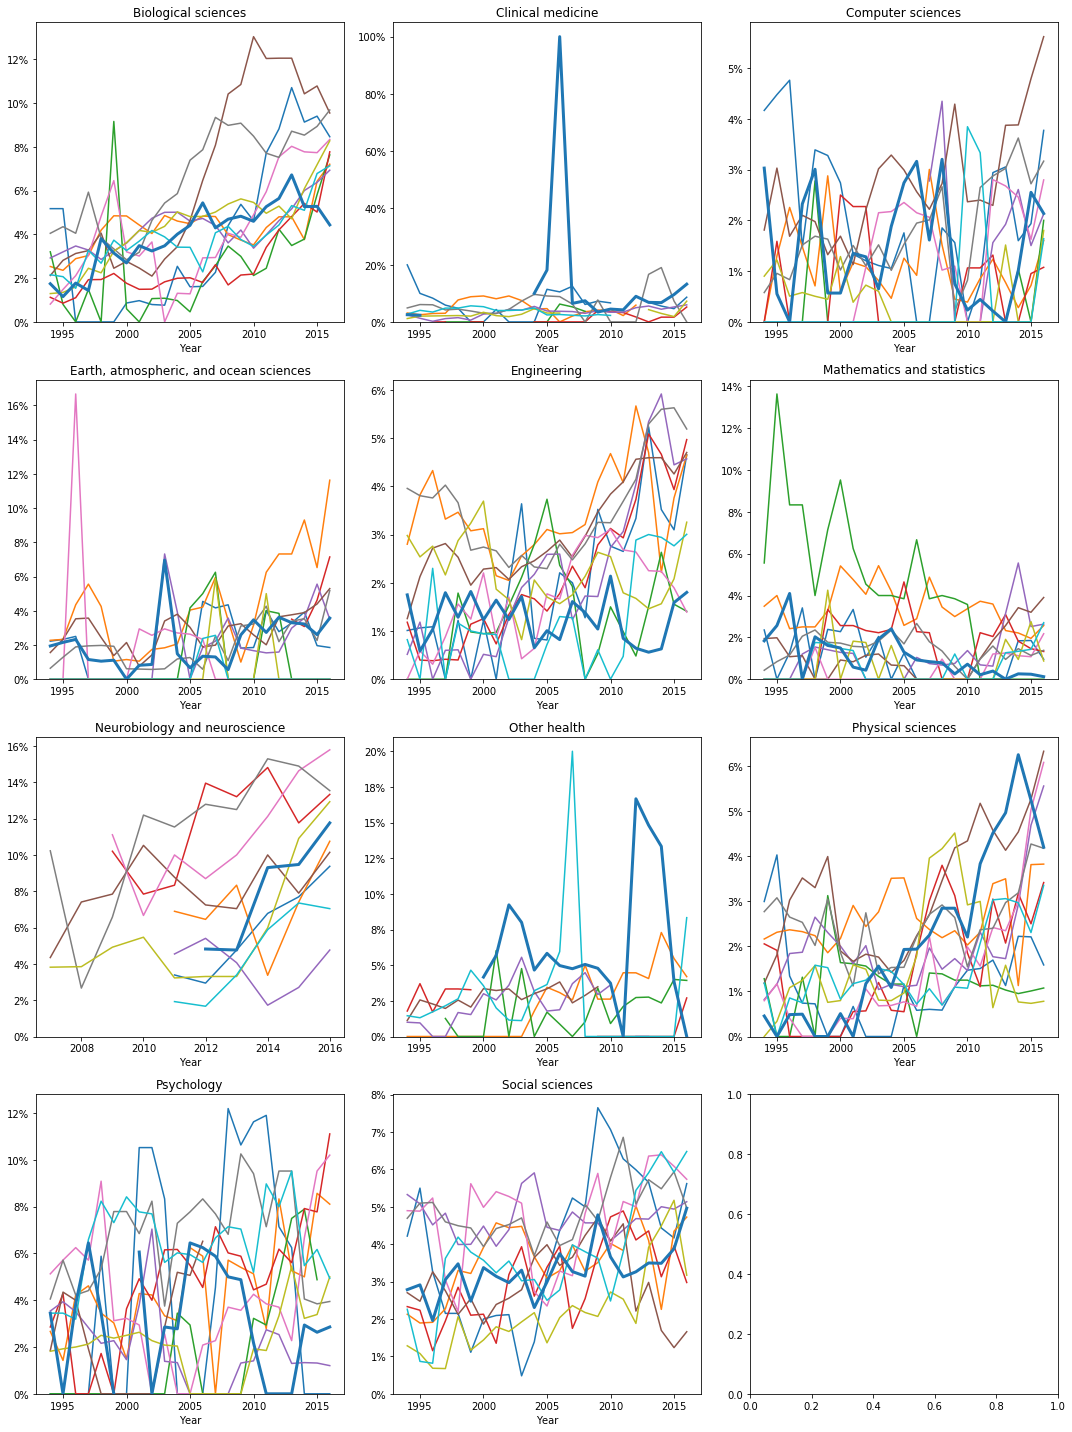

In [109]:
compare_insts_by_field('Hispanic or Latino ethnicity (one or more races)')

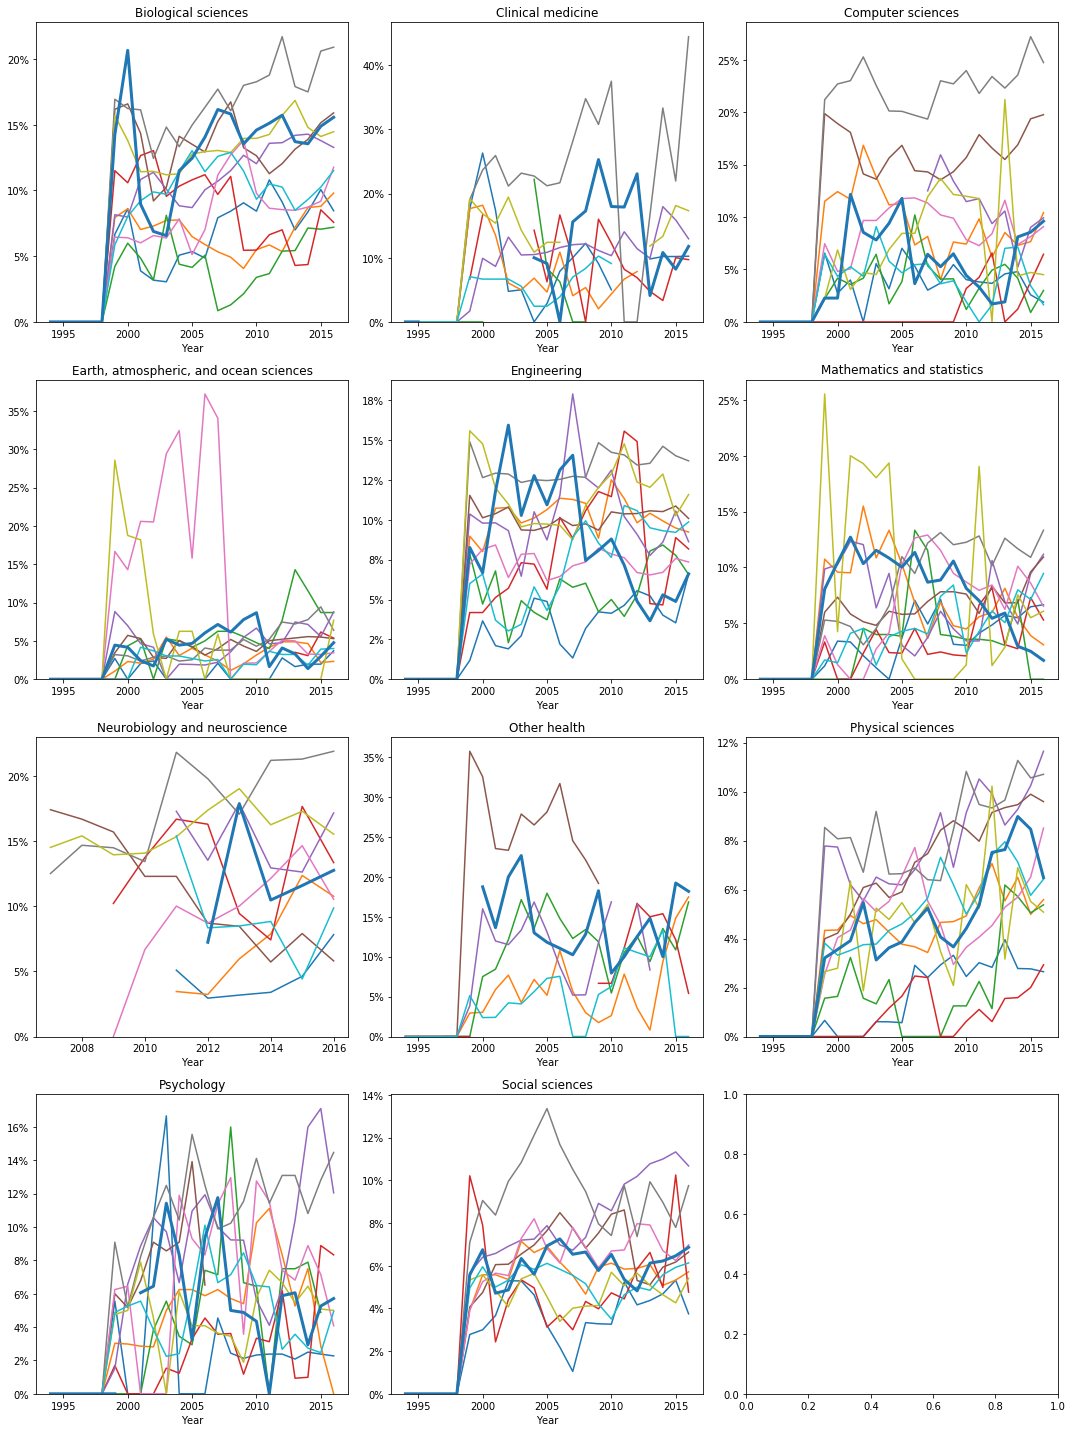

In [111]:
compare_insts_by_field('Non-Hispanic, Asian')

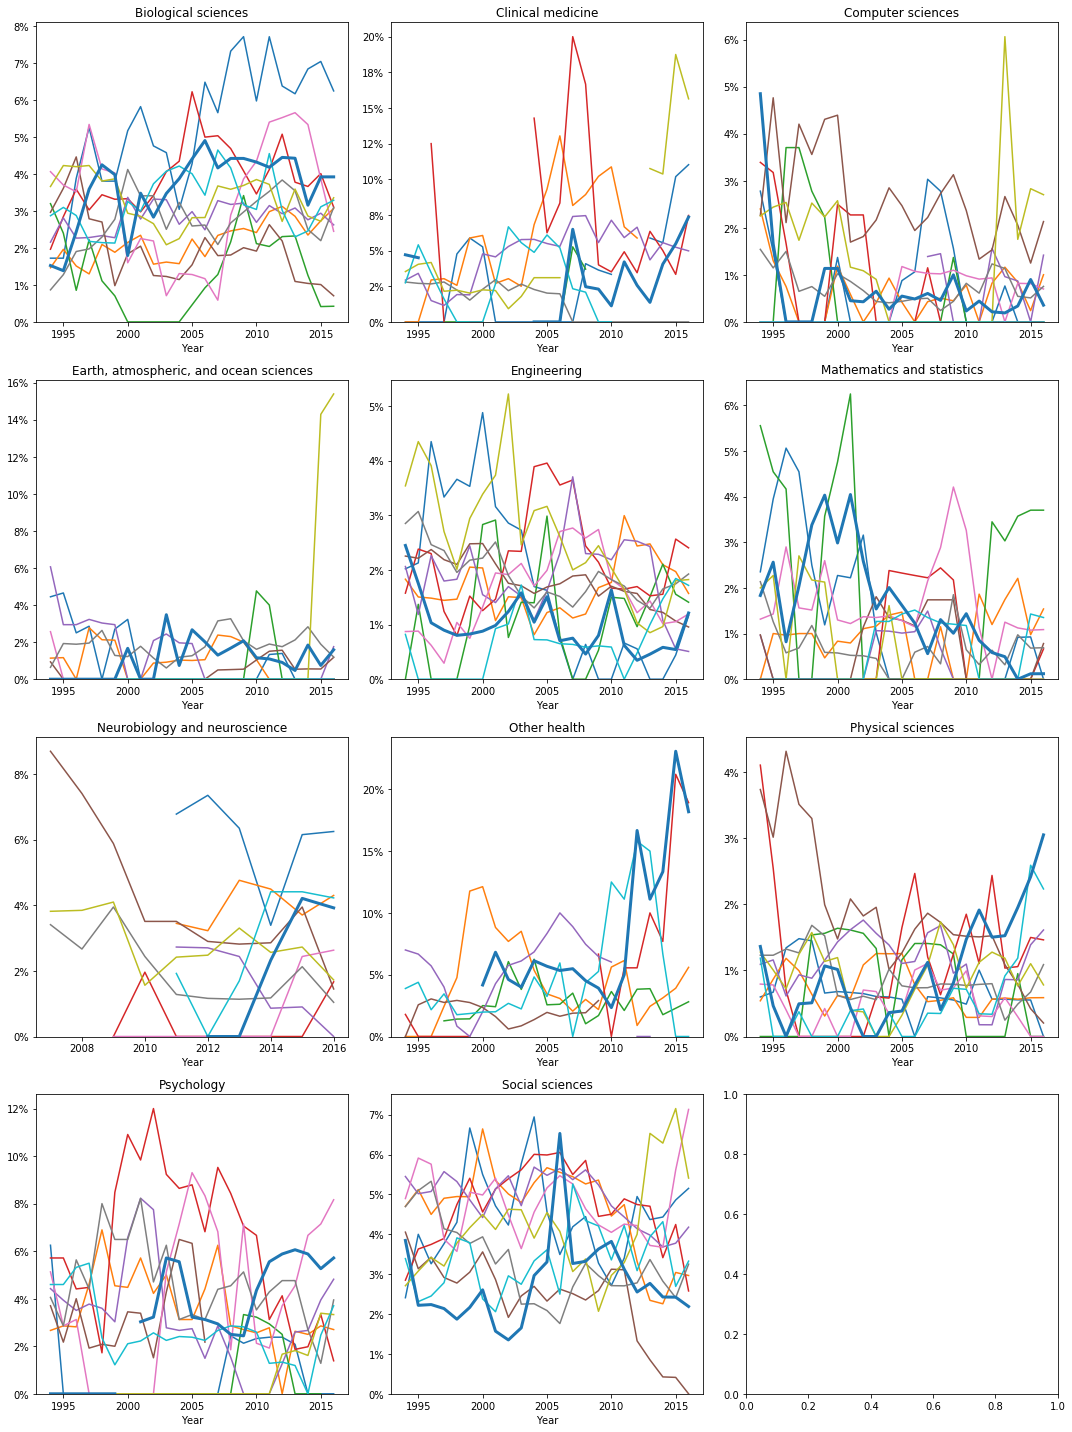

In [102]:
compare_insts_by_field('Non-Hispanic, black or African American')

Mathematics and sciences seems to be seeing a decline of minority representation, but that's likely due to the increasing population of international students. Let's plot that stack.

In [146]:
def plot_populations(ax, inst, field, ymax=None):
    for r in race_ethnicities:
        counts = []
        for year in years:
            field_counts = TOTALS[year][inst].get(field, None)
            if field_counts is None:
                counts.append(None)
                continue
            female = field_counts.get('Female', {}).get(r, 0)
            male = field_counts.get('Male', {}).get(r, 0)
            counts.append(female + male)
        ax.plot(years, counts, label=r, linewidth=2)

    ax.set_title(inst + ', ' + field)
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylim(bottom=0, top=ymax)

In [147]:
def examine_field(field):
    fig, ax = subplots(num=2, cols=2, size=10)
    stack_proportions(ax[0], 'Columbia University in the City of New York', field)
    plot_populations(ax[1], 'Columbia University in the City of New York', field, ymax=45)
    fig.tight_layout()

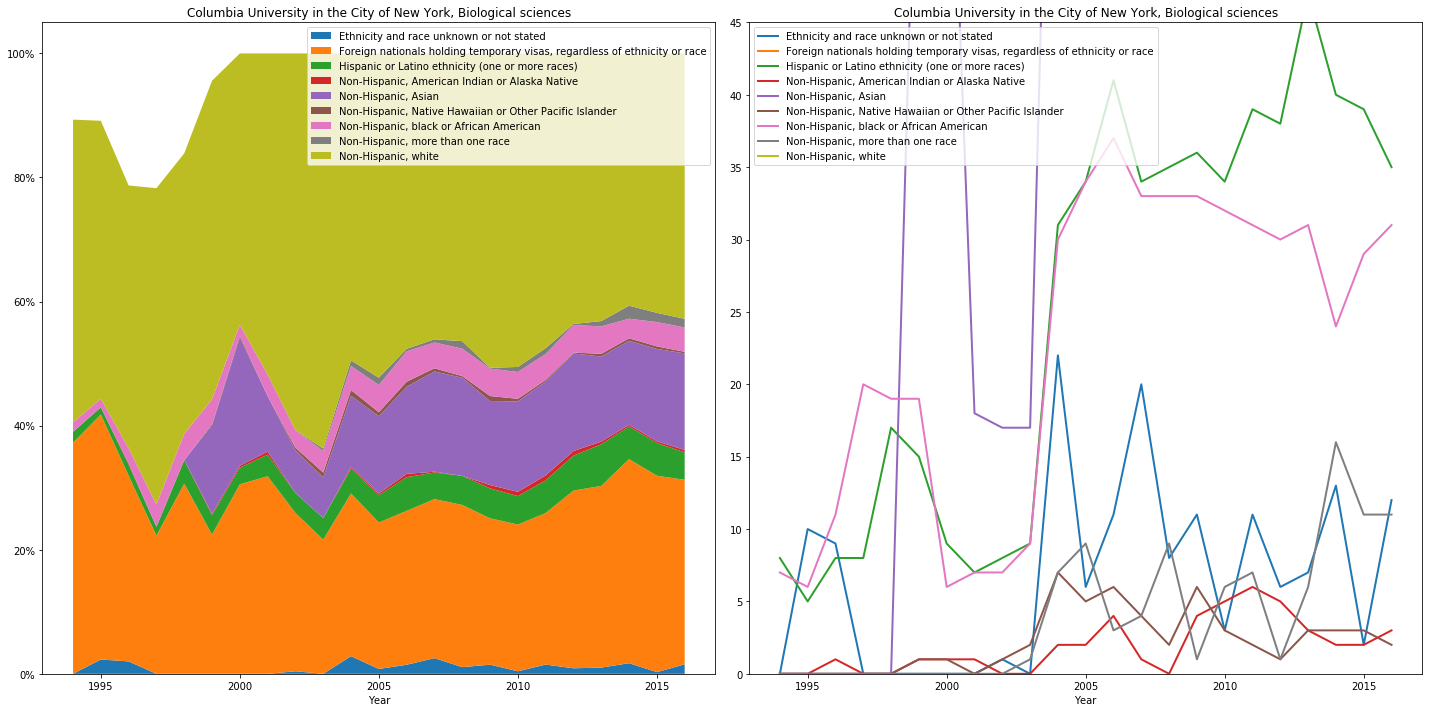

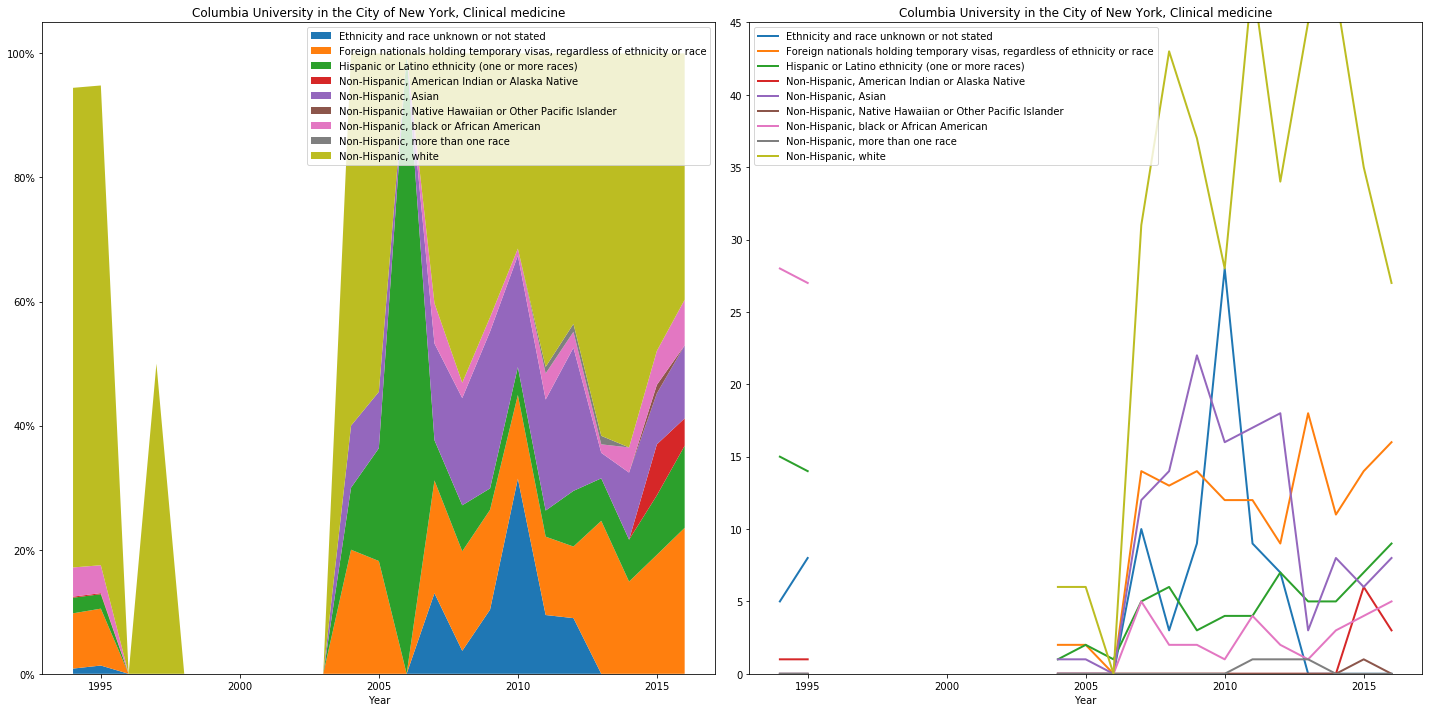

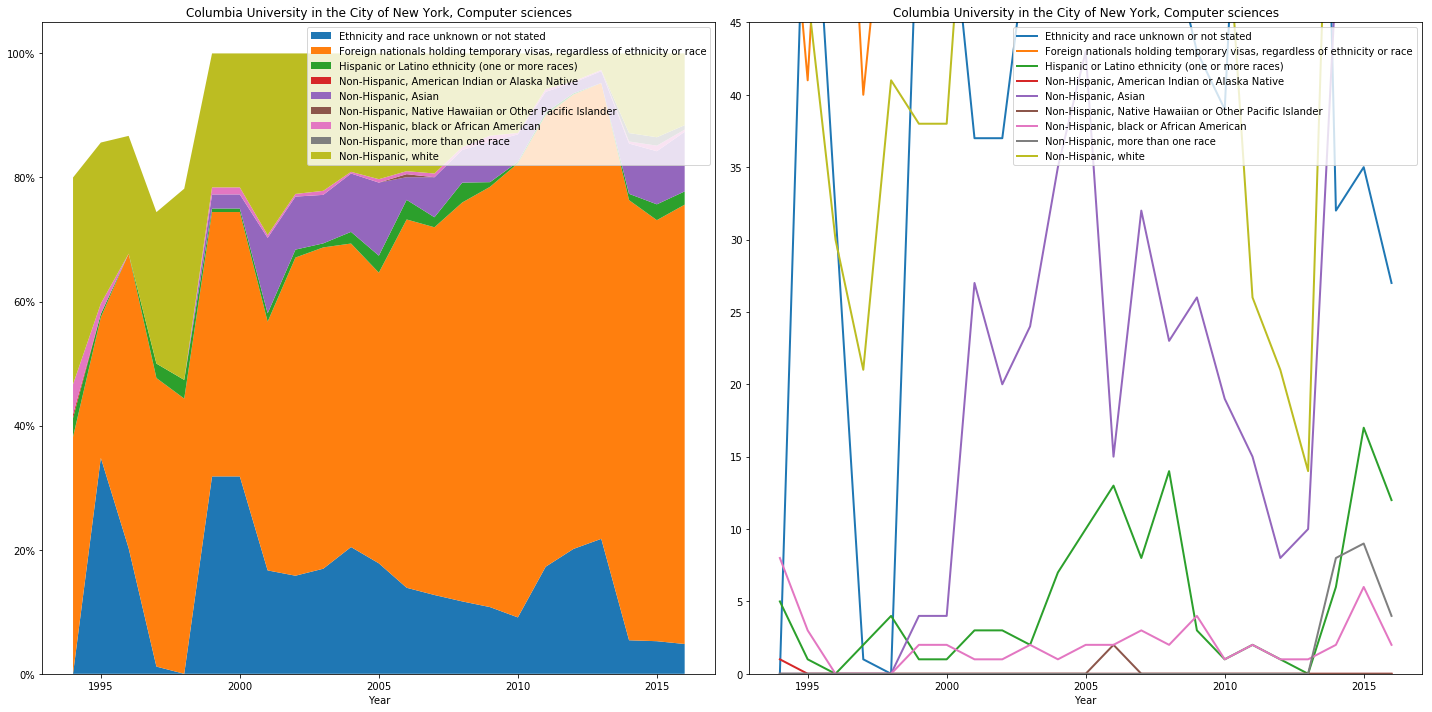

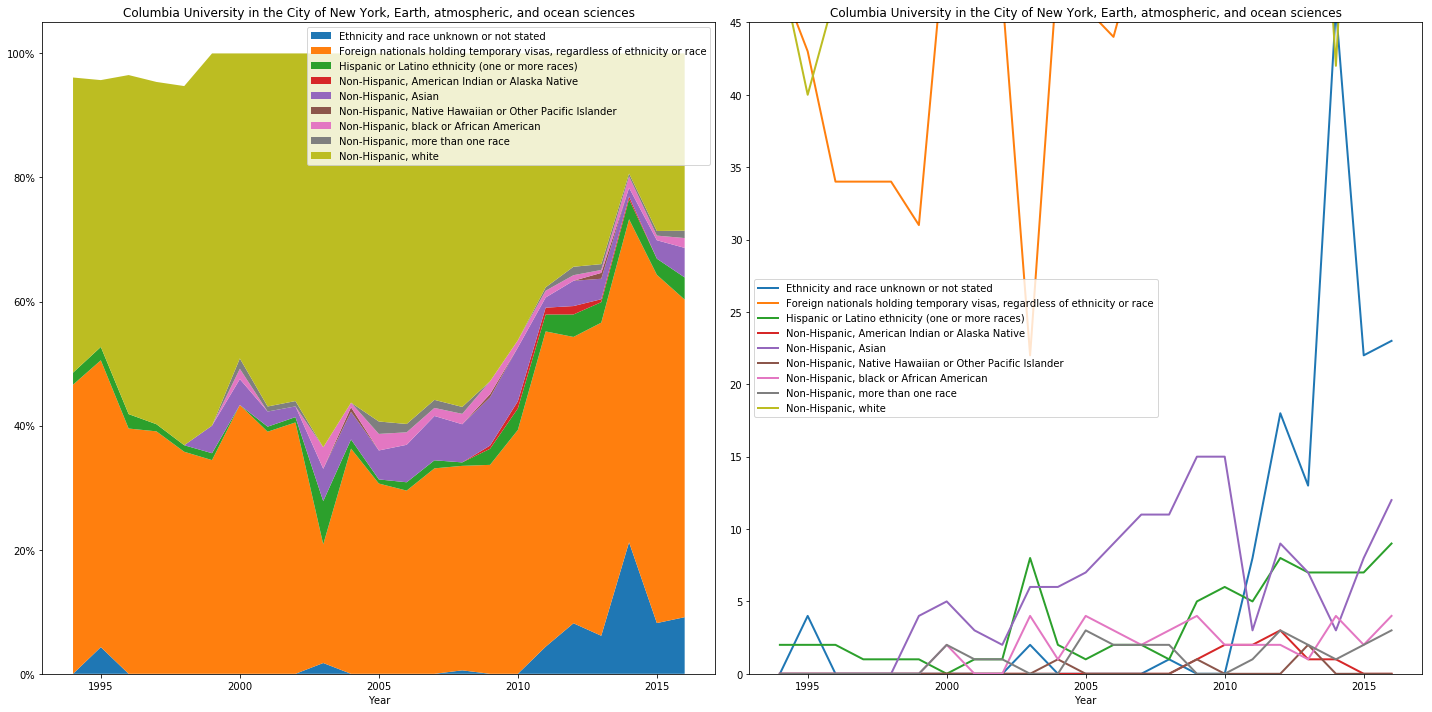

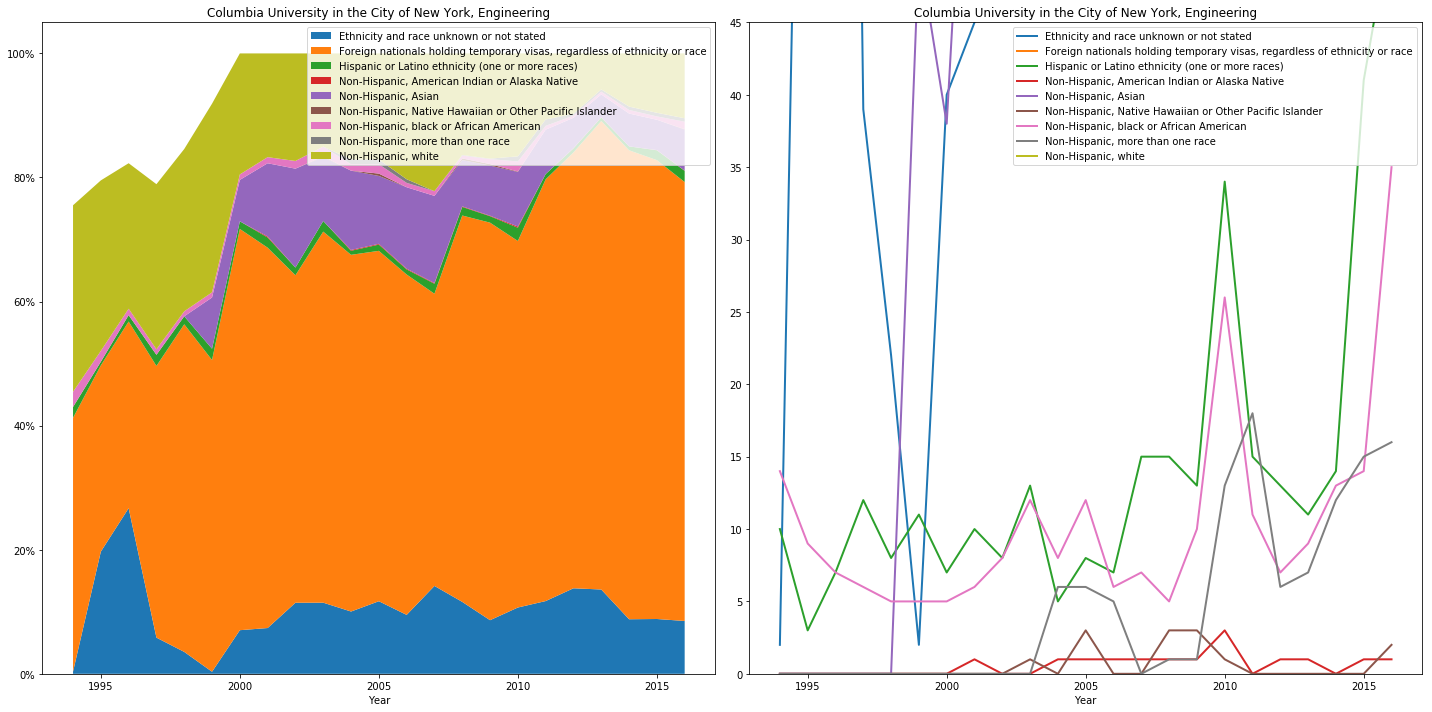

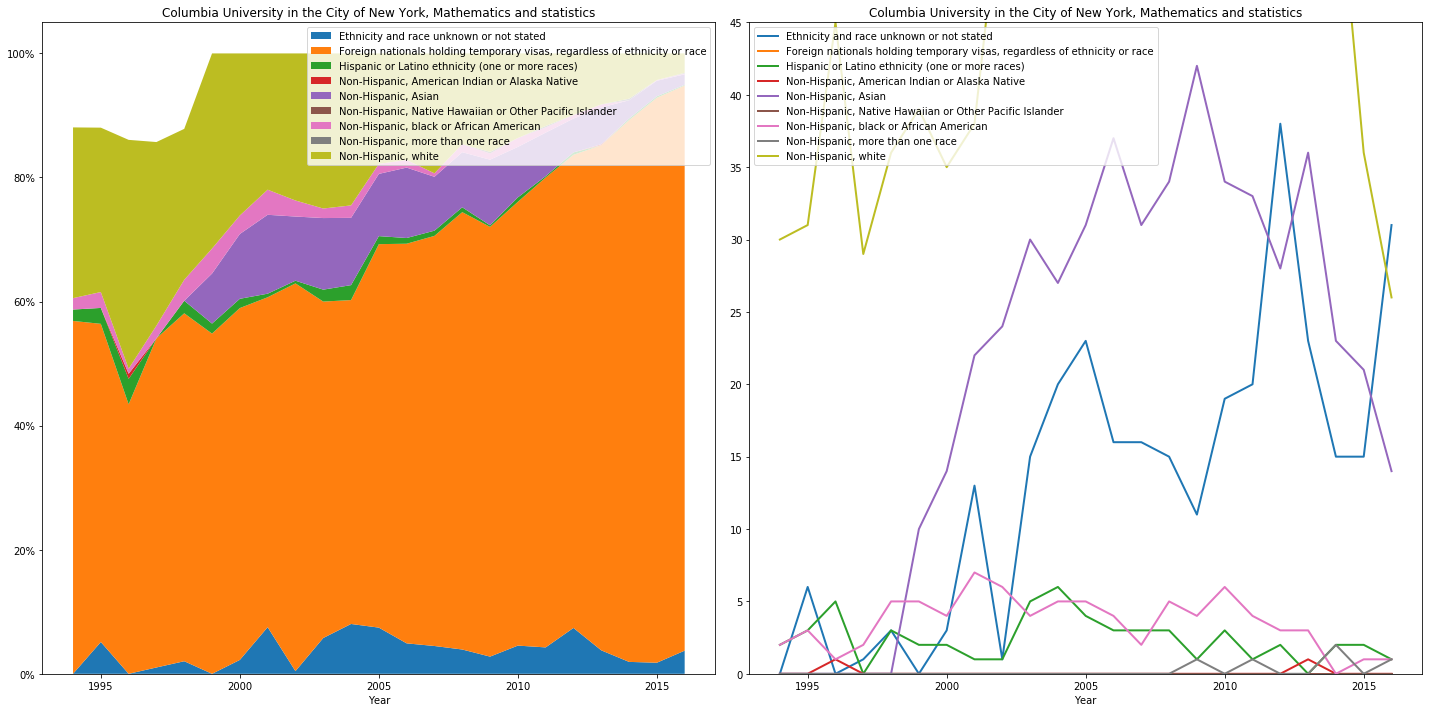

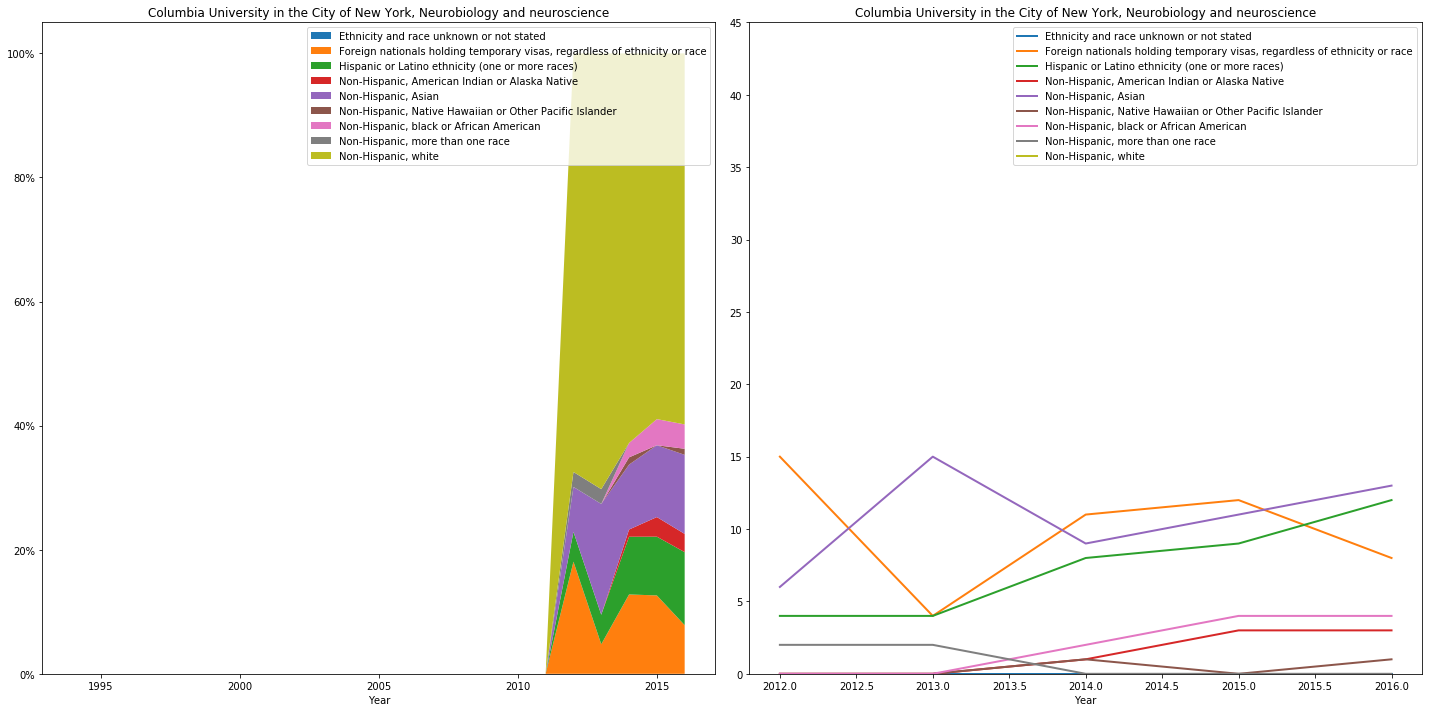

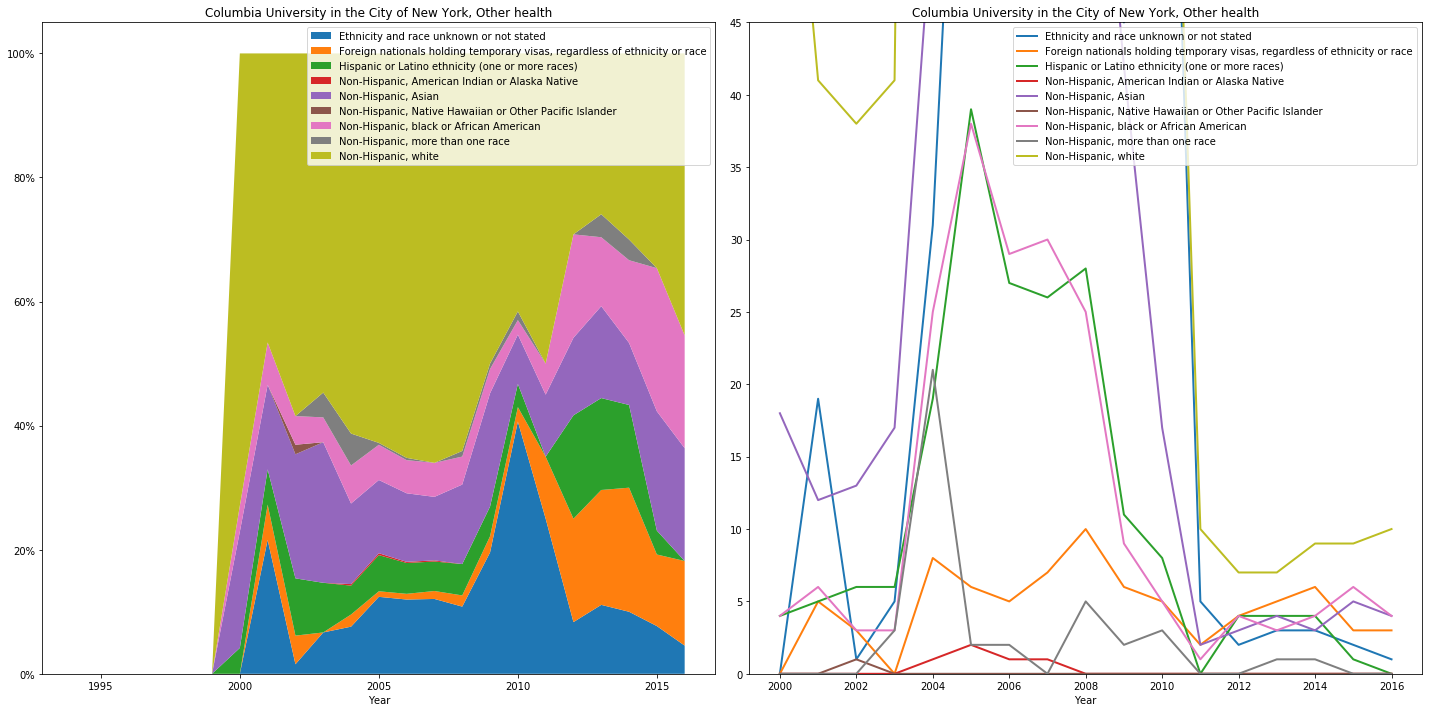

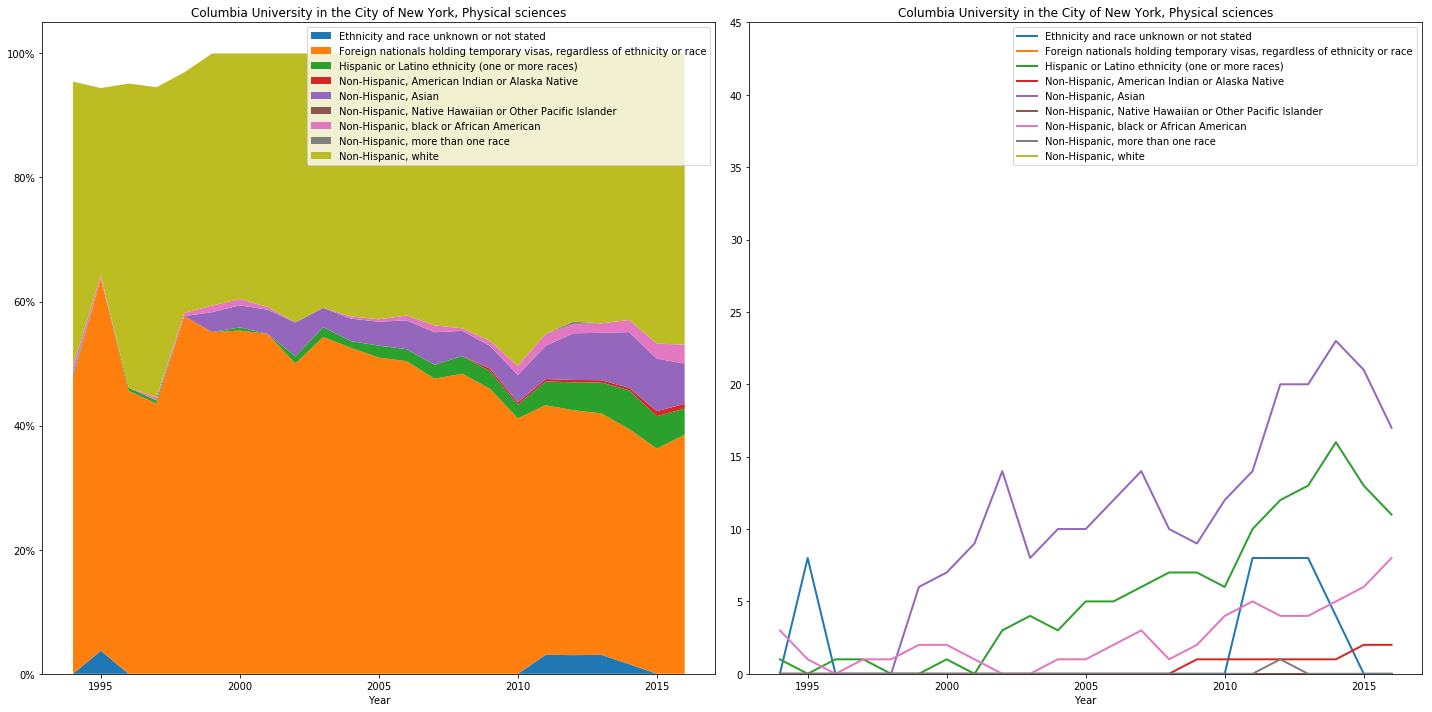

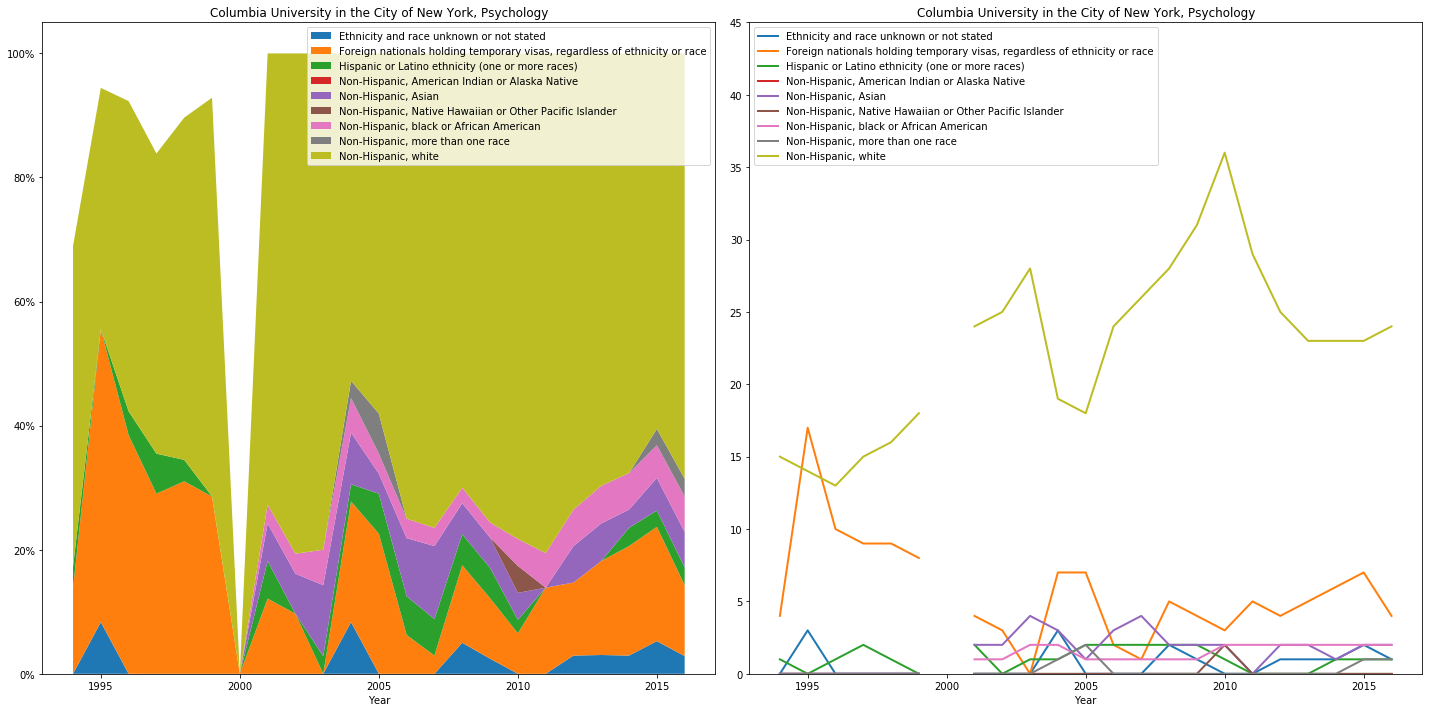

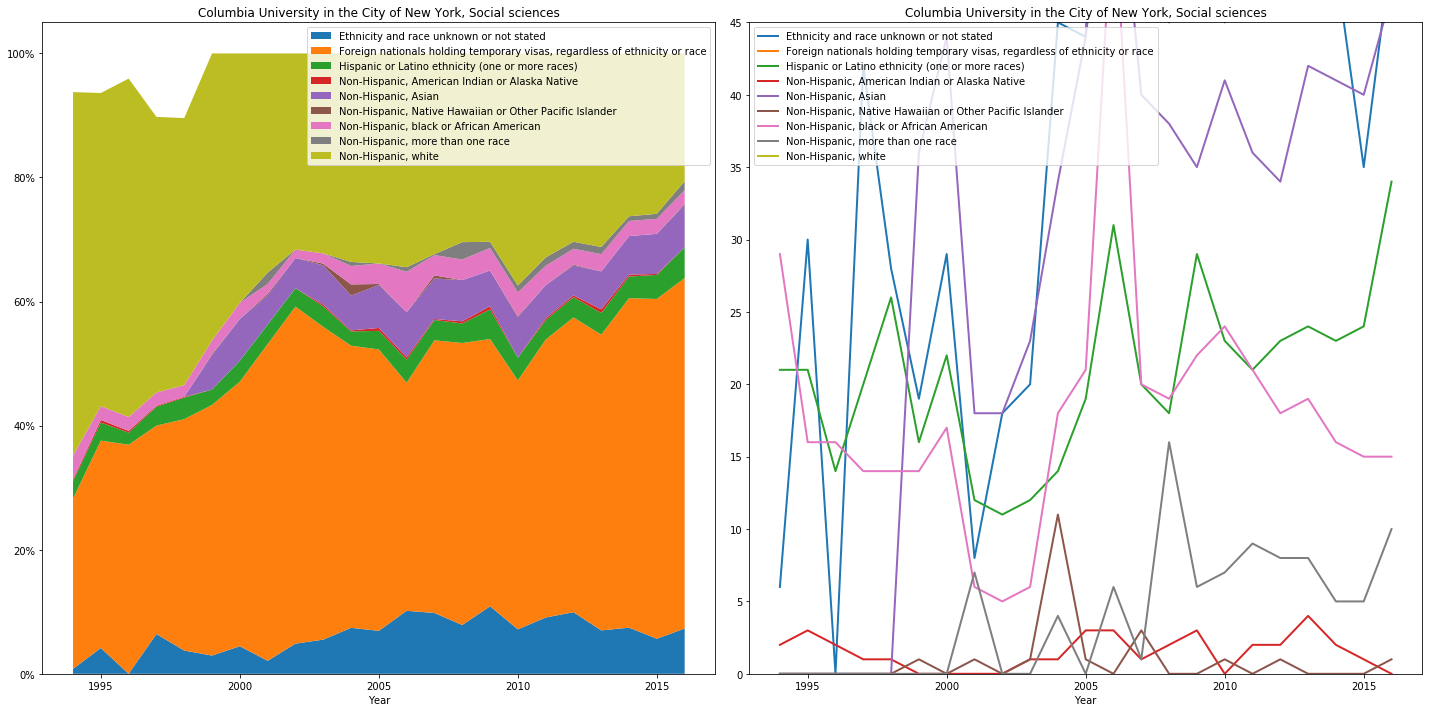

In [148]:
for field in fields:
    examine_field(field)